In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output
import time
from collections import defaultdict

class GridWorld:
    def __init__(self, size=8):
        self.size = size
        self.agent_pos = [0, 0]
        self.goal_pos = [size-1, size-1]
        self.obstacles = self._generate_obstacles()
        self.visited = set()
        self.step_count = 0
        self.max_steps = size * size * 2

    def _generate_obstacles(self):
        obstacles = set()
        n_obstacles = self.size
        while len(obstacles) < n_obstacles:
            pos = (np.random.randint(1, self.size-1),
                   np.random.randint(1, self.size-1))
            if pos != (0, 0) and pos != (self.size-1, self.size-1):
                obstacles.add(pos)
        return obstacles

    def reset(self):
        self.agent_pos = [0, 0]
        self.visited = {tuple(self.agent_pos)}
        self.step_count = 0
        return self._get_state()

    def _get_state(self):
        return {
            'position': tuple(self.agent_pos),
            'goal': self.goal_pos,
            'distance_to_goal': abs(self.agent_pos[0] - self.goal_pos[0]) +
                                abs(self.agent_pos[1] - self.goal_pos[1]),
            'visited_count': len(self.visited),
            'steps': self.step_count,
            'can_move': self._get_valid_actions()
        }

    def _get_valid_actions(self):
        valid = []
        moves = {'up': [-1, 0], 'down': [1, 0], 'left': [0, -1], 'right': [0, 1]}
        for action, delta in moves.items():
            new_pos = [self.agent_pos[0] + delta[0], self.agent_pos[1] + delta[1]]
            if (0 <= new_pos[0] < self.size and 0 <= new_pos[1] < self.size and
                tuple(new_pos) not in self.obstacles):
                valid.append(action)
        return valid

In [ ]:
class GridWorld(GridWorld):
    def step(self, action):
        self.step_count += 1
        moves = {'up': [-1, 0], 'down': [1, 0], 'left': [0, -1], 'right': [0, 1]}

        if action not in moves:
            return self._get_state(), -1, False, "Invalid action"

        delta = moves[action]
        new_pos = [self.agent_pos[0] + delta[0], self.agent_pos[1] + delta[1]]

        if not (0 <= new_pos[0] < self.size and 0 <= new_pos[1] < self.size):
            return self._get_state(), -1, False, "Hit wall"

        if tuple(new_pos) in self.obstacles:
            return self._get_state(), -1, False, "Hit obstacle"

        self.agent_pos = new_pos
        pos_tuple = tuple(self.agent_pos)
        reward = -0.1
        if pos_tuple not in self.visited:
            reward += 0.5
            self.visited.add(pos_tuple)

        done = False
        info = "Moved"
        if self.agent_pos == self.goal_pos:
            reward += 10
            done = True
            info = "Goal reached!"
        elif self.step_count >= self.max_steps:
            done = True
            info = "Max steps reached"

        return self._get_state(), reward, done, info

    def render(self, agent_thoughts=None):
        grid = np.zeros((self.size, self.size, 3))
        for pos in self.visited:
            grid[pos[0], pos[1]] = [0.7, 0.9, 1.0]
        for obs in self.obstacles:
            grid[obs[0], obs[1]] = [0.2, 0.2, 0.2]
        grid[self.goal_pos[0], self.goal_pos[1]] = [0, 1, 0]
        grid[self.agent_pos[0], self.agent_pos[1]] = [1, 0, 0]

        plt.figure(figsize=(10, 8))
        plt.imshow(grid, interpolation='nearest')
        plt.title(f"Step: {self.step_count} | Visited: {len(self.visited)}/{self.size*self.size}")
        for i in range(self.size + 1):
            plt.axhline(i - 0.5, color='gray', linewidth=0.5)
            plt.axvline(i - 0.5, color='gray', linewidth=0.5)
        if agent_thoughts:
            plt.text(0.5, -1.5, agent_thoughts, ha='center', fontsize=9,
                     bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8),
                     wrap=True, transform=plt.gca().transData)
        plt.axis('off')
        plt.tight_layout()
        plt.show()

In [ ]:
class ActionAgent:
    def __init__(self):
        self.q_values = defaultdict(lambda: defaultdict(float))
        self.epsilon = 0.3
        self.learning_rate = 0.1
        self.discount = 0.95

    def choose_action(self, state):
        valid_actions = state['can_move']
        if not valid_actions:
            return None
        pos = state['position']
        if np.random.random() < self.epsilon:
            action = np.random.choice(valid_actions)
            reasoning = f"Exploring randomly: chose '{action}'"
        else:
            action_values = {a: self.q_values[pos][a] for a in valid_actions}
            action = max(action_values, key=action_values.get)
            reasoning = f"Exploiting: chose '{action}' (Q={self.q_values[pos][action]:.2f})"
        return action, reasoning

    def learn(self, state, action, reward, next_state):
        pos = state['position']
        next_pos = next_state['position']
        current_q = self.q_values[pos][action]
        next_max_q = max([self.q_values[next_pos][a] for a in next_state['can_move']], default=0)
        new_q = current_q + self.learning_rate * (
            reward + self.discount * next_max_q - current_q)
        self.q_values[pos][action] = new_q

class ToolAgent:
    def analyze(self, state, action_taken, reward, history):
        suggestions = []
        distance = state['distance_to_goal']
        if distance <= 3:
            suggestions.append("🎯 Very close to goal! Prioritize direct path.")
        exploration_rate = state['visited_count'] / (state['steps'] + 1)
        if exploration_rate < 0.5 and distance > 5:
            suggestions.append("🔍 Low exploration rate. Consider exploring more.")
        if len(history) >= 5:
            recent_rewards = [h[2] for h in history[-5:]]
            avg_reward = np.mean(recent_rewards)
            if avg_reward < -0.5:
                suggestions.append("⚠️ Negative reward trend. Try different strategy.")
            elif avg_reward > 0.3:
                suggestions.append("✅ Good progress! Current strategy working.")
        if len(state['can_move']) <= 2:
            suggestions.append("🚧 Limited movement options. Be careful.")
        return suggestions

In [ ]:
class SupervisorAgent:
    def decide(self, state, proposed_action, tool_suggestions):
        if not proposed_action:
            return None, "No valid actions available"

        decision = proposed_action
        reasoning = f"Approved action '{proposed_action}'"

        for suggestion in tool_suggestions:
            if "goal" in suggestion.lower() and "close" in suggestion.lower():
                goal_direction = self._get_goal_direction(state)
                if goal_direction in state['can_move']:
                    decision = goal_direction
                    reasoning = f"Override: Moving '{goal_direction}' toward goal"
                    break

        return decision, reasoning

    def _get_goal_direction(self, state):
        pos = state['position']
        goal = state['goal']
        if goal[0] > pos[0]:
            return 'down'
        elif goal[0] < pos[0]:
            return 'up'
        elif goal[1] > pos[1]:
            return 'right'
        else:
            return 'left'

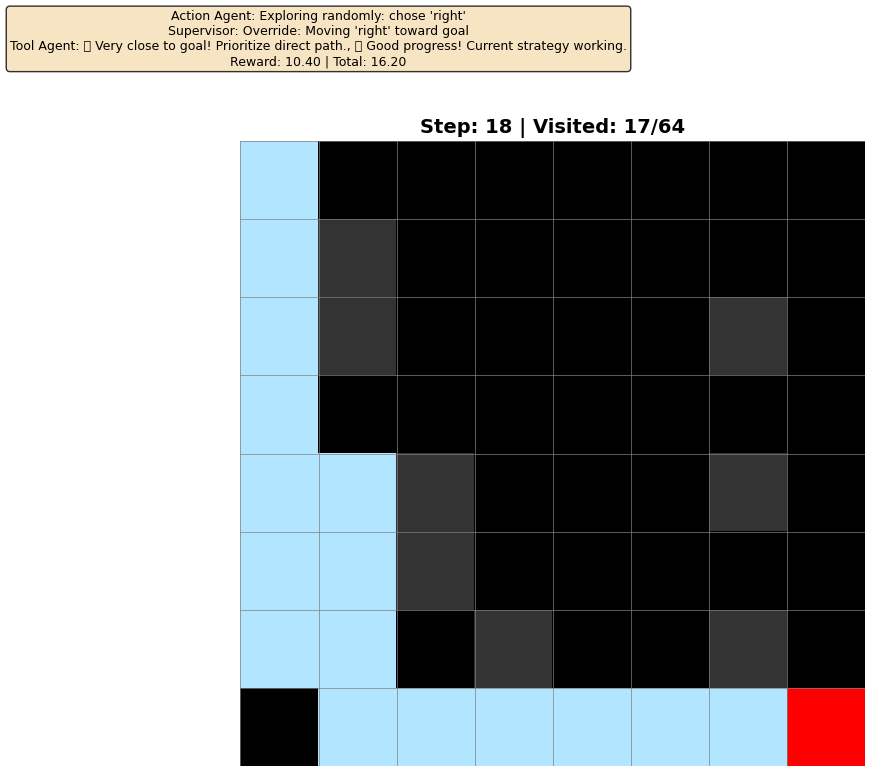


Episode 5 Complete!
Total Reward: 16.20
Steps Taken: 18
Cells Visited: 17/64


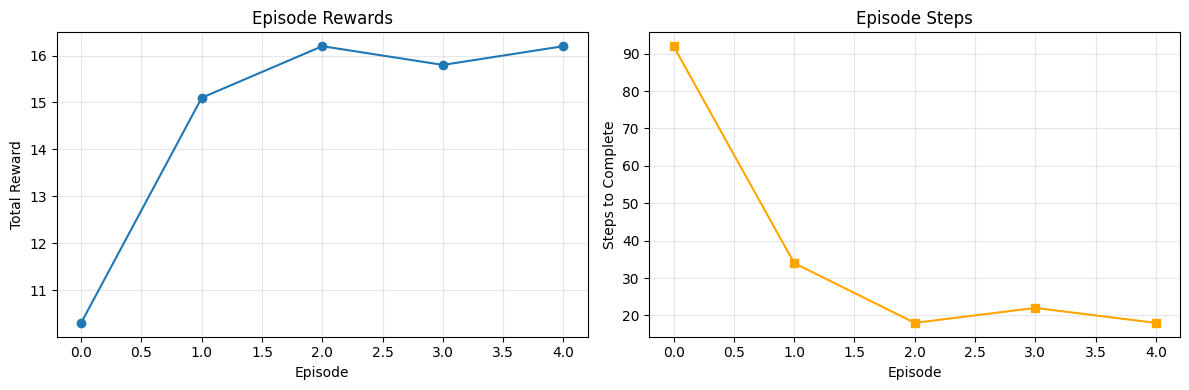

In [1]:
def train_multi_agent(episodes=5, visualize=True):
    env = GridWorld(size=8)
    action_agent = ActionAgent()
    tool_agent = ToolAgent()
    supervisor = SupervisorAgent()

    episode_rewards = []
    episode_steps = []

    for episode in range(episodes):
        state = env.reset()
        total_reward = 0
        done = False
        history = []

        print(f"\n{'='*60}")
        print(f"EPISODE {episode + 1}/{episodes}")
        print(f"{'='*60}")

        while not done:
            action_result = action_agent.choose_action(state)
            if action_result is None:
                break
            proposed_action, action_reasoning = action_result

            suggestions = tool_agent.analyze(state, proposed_action, total_reward, history)
            final_action, supervisor_reasoning = supervisor.decide(state, proposed_action, suggestions)

            if final_action is None:
                break

            next_state, reward, done, info = env.step(final_action)
            total_reward += reward
            action_agent.learn(state, final_action, reward, next_state)
            history.append((state, final_action, reward, next_state))

            if visualize:
                clear_output(wait=True)
                thoughts = (f"Action Agent: {action_reasoning}\n"
                           f"Supervisor: {supervisor_reasoning}\n"
                           f"Tool Agent: {', '.join(suggestions[:2]) if suggestions else 'No suggestions'}\n"
                           f"Reward: {reward:.2f} | Total: {total_reward:.2f}")
                env.render(thoughts)
                time.sleep(0.3)

            state = next_state

        episode_rewards.append(total_reward)
        episode_steps.append(env.step_count)

        print(f"\nEpisode {episode+1} Complete!")
        print(f"Total Reward: {total_reward:.2f}")
        print(f"Steps Taken: {env.step_count}")
        print(f"Cells Visited: {len(env.visited)}/{env.size**2}")

    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(episode_rewards, marker='o')
    plt.title('Episode Rewards')
    plt.xlabel('Episode')
    plt.ylabel('Total Reward')
    plt.grid(True, alpha=0.3)

    plt.subplot(1, 2, 2)
    plt.plot(episode_steps, marker='s', color='orange')
    plt.title('Episode Steps')
    plt.xlabel('Episode')
    plt.ylabel('Steps to Complete')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    return action_agent, tool_agent, supervisor

if __name__ == "__main__":
    print("🤖 Multi-Agent RL System: Grid World Navigation")
    print("=" * 60)
    print("Components:")
    print("  • Action Agent: Proposes actions using Q-learning")
    print("  • Tool Agent: Analyzes performance and suggests improvements")
    print("  • Supervisor Agent: Makes final decisions")
    print("=" * 60)

    trained_agents = train_multi_agent(episodes=5, visualize=True)